# 1: init:

In [39]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import math
plt.rcParams["figure.figsize"]=[12., 8.]

import pandas as pd

from xls2dict import xls2dict
from fivepoint import derive

from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets
from IPython.display import display

from math import factorial#, log10
from types import MethodType
from math import isnan
from IPython.display import clear_output
import inspect
# ----------------------------------------------------------------
def savitzky_golay(y, window_size, order, deriv=0, rate=1):
    order_range = range(order+1)
    half_window = (window_size -1) // 2
    # precompute coefficients
    b = np.mat([[k**i for i in order_range]
                      for k in range(-half_window, half_window+1)])
    m = np.linalg.pinv(b).A[deriv] * rate**deriv * factorial(deriv)
    # pad the signal at the extremes with
    # values taken from the signal itself
    firstvals = y[0] - np.abs( y[1:half_window+1][::-1] - y[0] )
    lastvals = y[-1] + np.abs(y[-half_window-1:-1][::-1] - y[-1])
    y = np.concatenate((firstvals, y, lastvals))
    return np.convolve( m[::-1], y, mode='valid')

class xlsdata(xls2dict):
    def cregion(self, df,col):
        for _j in range(4,df.shape[0]):
            if isnan(df.iloc[_j,col]):
                return (df.iloc[4:_j,col].values,df.iloc[4:_j,col+1].values)
            else: _j+=1
    def __init__(self, *source):
        xls2dict.__init__(self, *source)
        self.sheets = [[_,[]] for _ in sorted(self.data, key=lambda x: int(x.split(u'°C')[0]))]
        self.XX = [float(_[0].split(u'°C')[0]) for _ in self.sheets]
        _j = 0
        for _s in self.sheets:
            yx = self.data[_s[0]]
            self.sheets[_j][1] = ["%s:%d" % (yx.iloc[1,_],_-1) for _ in range(1,yx.shape[1],3)]
            _j+=1
    def evaluate(self,sheet,nreg):
        yx = self.data[sheet]
        cr = self.cregion(yx, nreg)
        dydx = np.array([_ for _ in derive(cr[0], cr[1])])*0.01
        dpos = dydx>0.
        self.dY = dydx[dpos]
        self.x = (cr[0]/np.abs(cr[0]).max())[dpos]
        self.ds = savitzky_golay(self.dY, 2*int(0.02*len(dydx))+1, 1,0,1)
        dsmin = self.ds.argmin()
        self.xmin = self.x[dsmin]
        self.ymin = self.ds[dsmin]
        return self.ymin
    def makeplot(self,sheet,plot):
        oneplot = plot.split(':')
        self.evaluate(sheet,int(oneplot[1]))
        plt.title("%s [%s:%s]\nmin = %s(%s)" % (sheet,oneplot[0],oneplot[1], xls2.ymin,xls2.xmin))
        #plt.semilogy(self.x, self.dY, ':', self.x,self.ds,'-', self.xmin,self.ymin,'ok');
        plt.plot(self.x, self.dY, ':', self.x,self.ds,'-', self.xmin,self.ymin,'ok');
        plt.annotate('', xy=(self.xmin, self.ymin*0.7), xytext=(self.xmin, self.ymin));
        plt.show()

class trend:
    def __init__(self, axx):
        self.axx = axx
        self.lines = [None,]*len(axx.lines)
    def make(self, f,n=0):
        _l = self.axx.lines[n]
        xx = _l.get_data()[0]
        xx.sort()
        #print _l.get_label(), xx
        if self.lines[n]: self.lines[n].remove()
        #self.lines[n], = self.axx.semilogy(xx, map(f,xx), color=_l.get_color(),label="trend %s" % _l.get_label())
        self.lines[n], = self.axx.plot(xx, map(f,xx), color=_l.get_color(),label="trend %s" % _l.get_label())
        self.axx.legend()
    def printg(self):
        for l2d_ in self.lines:
            ld_ = l2d_.get_data()
            print
            print l2d_.get_label()
            print "trend X:",
            for i0, _ in enumerate(ld_[0]):
                print ld_[0][i0],
            print
            print "trend Y:",
            for i0, _ in enumerate(ld_[0]):
                print ld_[1][i0],
            print    

            Y_2 = ld_[1][-1]
            Y_1 = ld_[1][0]
            dY = Y_2 - Y_1
            dX = ld_[0][-1]-ld_[0][0]
            print "dX = %r - %r = %r;" % (ld_[0][-1],ld_[0][0], dX)
            print "dY = %r - %r = %r;" % (ld_[1][-1],ld_[1][0], dY)
            print "dY/dX = %r / %r = %r;" % (dY,dX, dY/dX)           

# 2: UPLOAD workbook:

In [ ]:
xls2 = xlsdata()

# 3: READ workbook from local file:

In [3]:
xls2 = xlsdata('Creep.xls')

File 'Creep.xls' readed successfully!


# 4: calculation ALL derivative:

In [4]:
vitesse_all_T = {}
for _i in xls2.sheets:
    vitesse_all_T[_i[0]] = []
    vitesse_all_T[_i[0]].append(map(lambda x:float(x.split(':')[0]),_i[1]))
    nreg = map(lambda x:int(x.split(':')[1]),_i[1])
    vitesse_all_T[_i[0]].append(map(lambda x:xls2.evaluate(_i[0],x),nreg))    

# 5: plotting ONE derivative with user interface:

<IPython.core.display.Javascript object>


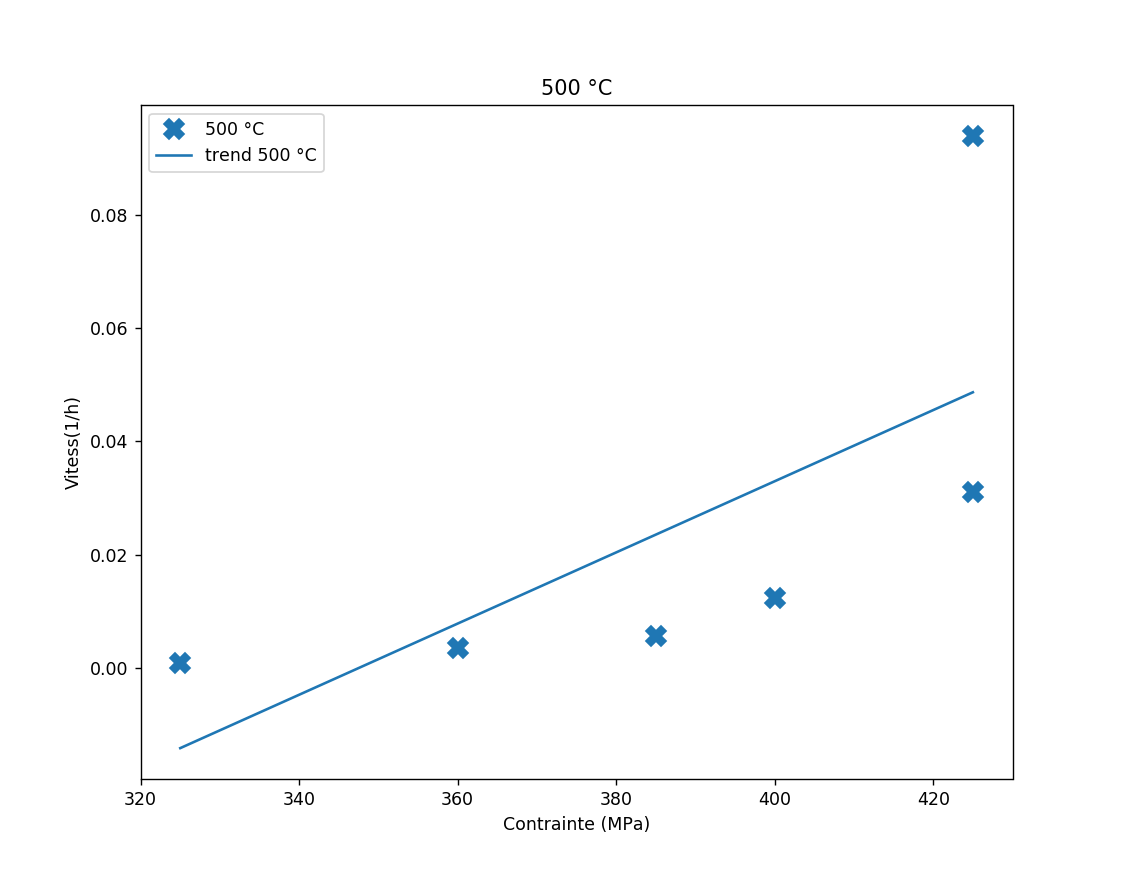

In [10]:
%matplotlib notebook
mtrend1 = None
def sheet_select(x):
    wbt.description=x
def derive_make(b):
    clear_output()
    plt.rcParams["figure.figsize"]=[9., 7.]
    global mtrend1
    _k = b.description
    #print `_k`
    x,y = vitesse_all_T[_k]
    _f, _ax = plt.subplots()
    #_ax.semilogy(x, y, marker = 'X',label=_k, ms=12,linestyle='None')
    _ax.plot(x, y, marker = 'X',label=_k, ms=12,linestyle='None')
    plt.ylabel('Vitess(1/h)')
    plt.xlabel('Contrainte (MPa)')
    plt.title(_k)
    plt.legend(loc='best');
    mtrend1 = trend(_ax)
    
wsh = widgets.Select(options=map(lambda x:x[0],xls2.sheets))
wbt = widgets.Button(description=wsh.value)
wbt.on_click(derive_make)
hh = widgets.HBox([wsh,wbt])
interactive(sheet_select,x=wsh)
display(hh)

In [6]:
def anno():
    ax0 = mtrend1.axx.figure.axes[0]
    ln0 = ax0.lines[0].get_data()
    for i0, _ in enumerate(ln0[0]):    
        ax0.annotate("(%r,\n %r)" % (ln0[0][i0], ln0[1][i0]), (ln0[0][i0], ln0[1][i0]))
anno()

# 6.0: trending derivatives (config):

In [40]:
xls2.trend = [None, []]
# set trend model function:
#xls2.trend[0] = lambda a: lambda x: math.exp(x*a[0]+a[1])
xls2.trend[0] = lambda a: lambda x: x*a[0]+a[1]
# sets coeficients of model function:
for _ in xls2.sheets:
  print _[0]
  x_y = vitesse_all_T[_[0]]
  kf = np.polyfit(x_y[0], x_y[1], 1)
  xls2.trend[1].append((kf[0],kf[1]))
xls2.trend[1]

500 °C
600°C
700°C
800°C
900°C
1000°C
1100°C
1200°C
1300°C


[(0.0006277557431881881, -0.21812264556557123),
 (0.00053986841479676333, -0.074448014449197158),
 (0.0015958784547884023, -0.052138034574323089),
 (0.0041781378463855408, -0.10015356407846529),
 (0.0043765240824381012, -0.060944634574894727),
 (0.012057167483161794, -0.13897632683411903),
 (0.026309668499956342, -0.13943558948566792),
 (0.04890206687355457, -0.15042827552492874),
 (0.040178901166782792, -0.041170226022157995)]

# 6.1: trending current derivative:

In [41]:
mtrend1.make(xls2.trend[0](xls2.trend[1][wsh.options.index(wsh.value)]))
mtrend1.printg()


trend 500 °C
trend X: 325.0 360.0 385.0 400.0 425.0 425.0
trend Y: -0.0141020290294 0.00786942198218 0.0235633155619 0.0329796517097 0.0486735452894 0.0486735452894
dX = 425.0 - 325.0 = 100.0;
dY = 0.048673545289408732 - -0.014102029029410101 = 0.062775574318818833;
dY/dX = 0.062775574318818833 / 100.0 = 0.00062775574318818831;


# 7: plotting ALL derivatives in common:

<IPython.core.display.Javascript object>


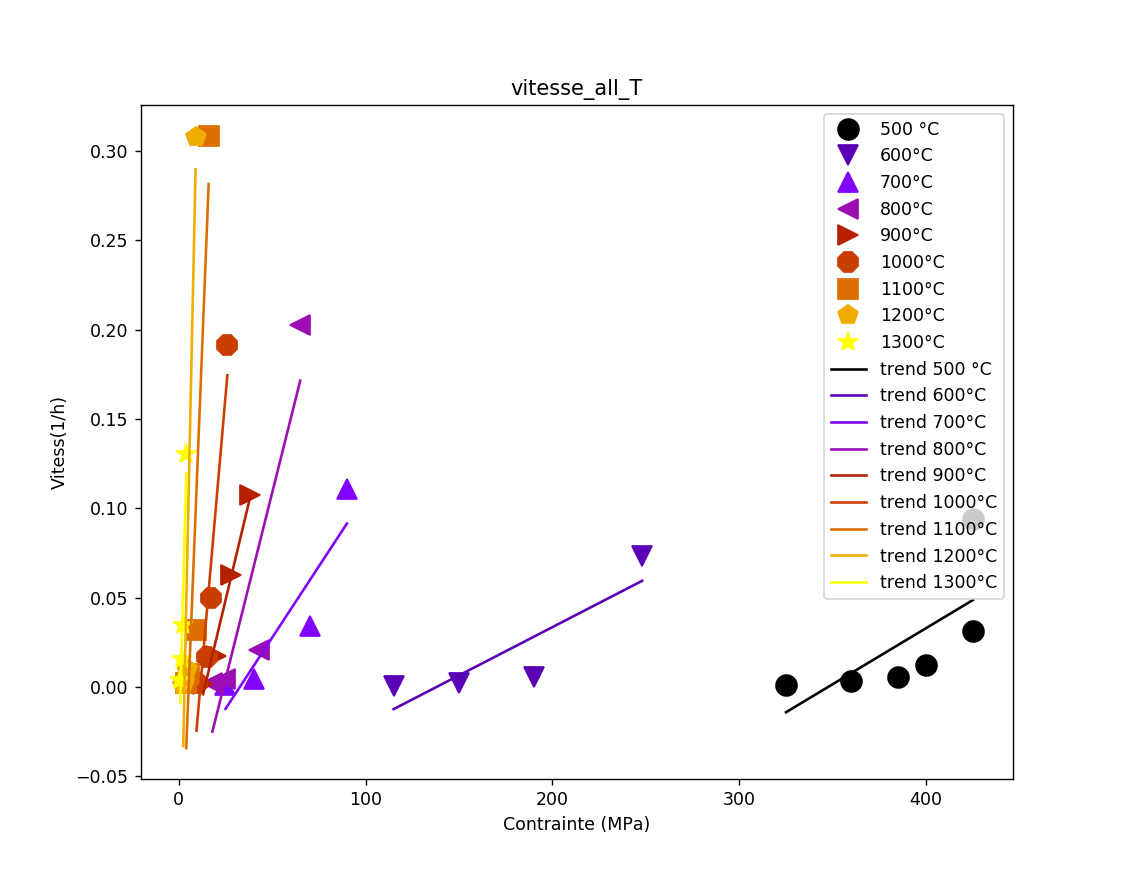

In [42]:
%matplotlib notebook
#from scipy.optimize import curve_fit
#inline notebook
plt.rcParams["figure.figsize"]=[9., 7.]
#markers = [(2+i/2, 1+i%2, 0) for i in range(16)]
markers = ('o', 'v', '^', '<', '>', '8', 's', 'p', '*', 'h', 'H', 'D', 'd', 'P', 'X')
cmap = plt.get_cmap('gnuplot')
colors = [cmap(i) for i in np.linspace(0, 1, len(xls2.sheets))]

i=0
_f, _ax = plt.subplots()
for _ in xls2.sheets:
    _k = _[0]
    #x,y = map(lambda q:np.array(q), vitesse_all_T[_k])
    x,y = vitesse_all_T[_k]
    #_ax.semilogy(x, y,  color=colors[i], label= _k, marker = markers[i],ms=12,linestyle='None')
    _ax.plot(x, y,  color=colors[i], label= _k, marker = markers[i],ms=12,linestyle='None')
    i+=1

plt.ylabel('Vitess(1/h)')
plt.xlabel('Contrainte (MPa)')
plt.title('vitesse_all_T')
plt.legend(loc='best');

mtrend2 = trend(_ax)

# 7.1: trending ALL derivatives in common:

In [43]:
for _,v in enumerate(xls2.sheets):
    mtrend2.make(xls2.trend[0](xls2.trend[1][_]),_)
mtrend2.printg()


trend 500 °C
trend X: 325.0 360.0 385.0 400.0 425.0 425.0
trend Y: -0.0141020290294 0.00786942198218 0.0235633155619 0.0329796517097 0.0486735452894 0.0486735452894
dX = 425.0 - 325.0 = 100.0;
dY = 0.048673545289408732 - -0.014102029029410101 = 0.062775574318818833;
dY/dX = 0.062775574318818833 / 100.0 = 0.00062775574318818831;

trend 600°C
trend X: 115.0 150.0 190.0 248.0
trend Y: -0.0123631467476 0.00653224777032 0.0281269843622 0.0594393524204
dX = 248.0 - 115.0 = 133.0;
dY = 0.05943935242040016 - -0.012363146747569373 = 0.071802499167969533;
dY/dX = 0.071802499167969533 / 133.0 = 0.00053986841479676344;

trend 700°C
trend X: 25.0 40.0 70.0 90.0
trend Y: -0.0122410732046 0.0116971036172 0.0595734572609 0.0914910263566
dX = 90.0 - 25.0 = 65.0;
dY = 0.091491026356633115 - -0.012241073204613033 = 0.10373209956124615;
dY/dX = 0.10373209956124615 / 65.0 = 0.0015958784547884025;

trend 800°C
trend X: 18.0 25.0 43.0 65.0
trend Y: -0.0249470828435 0.00429988208117 0.0795063633161 0.1714253

# 7.2: trending ALL derivatives apart:

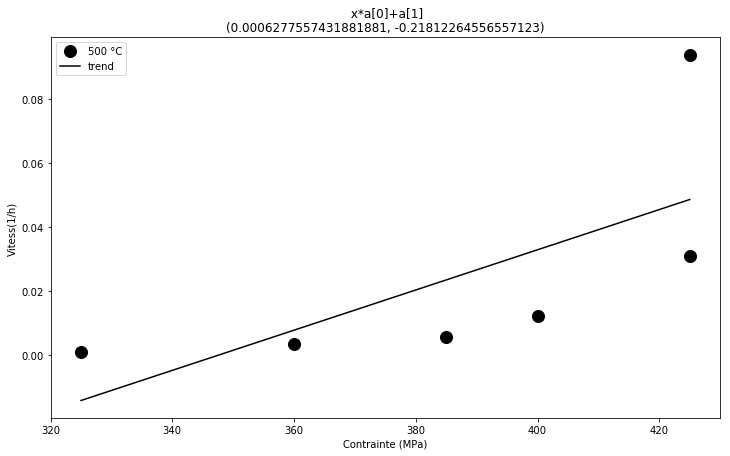

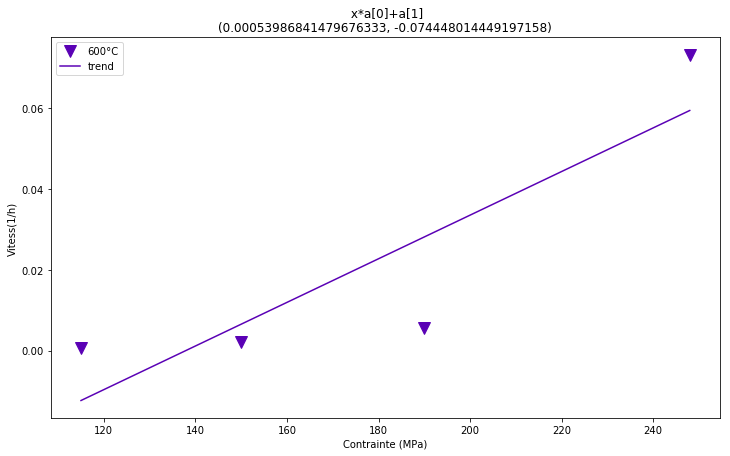

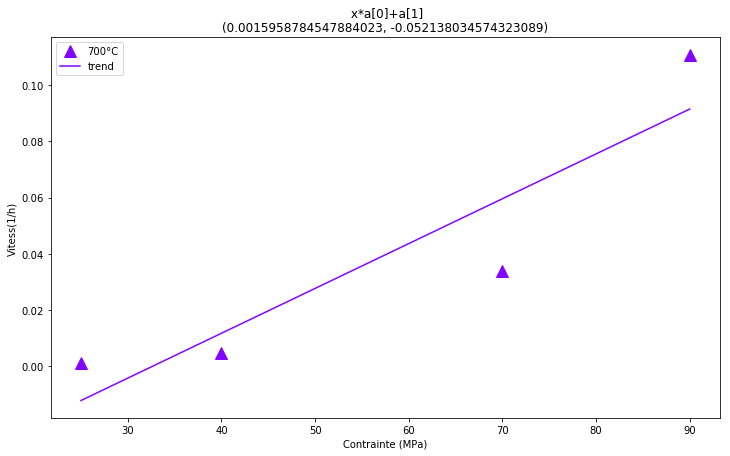

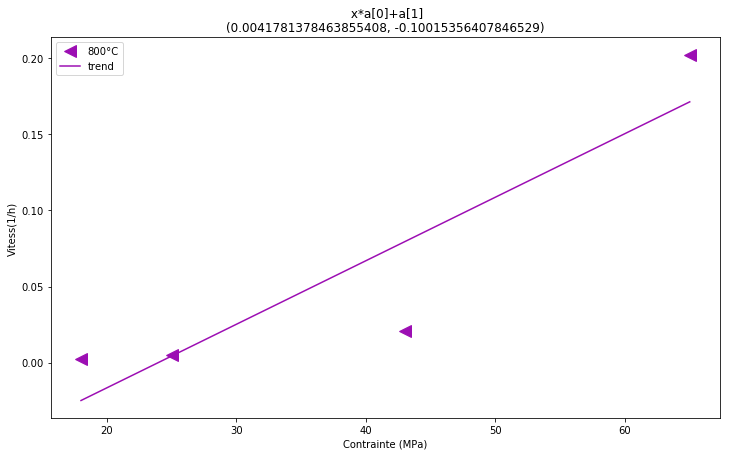

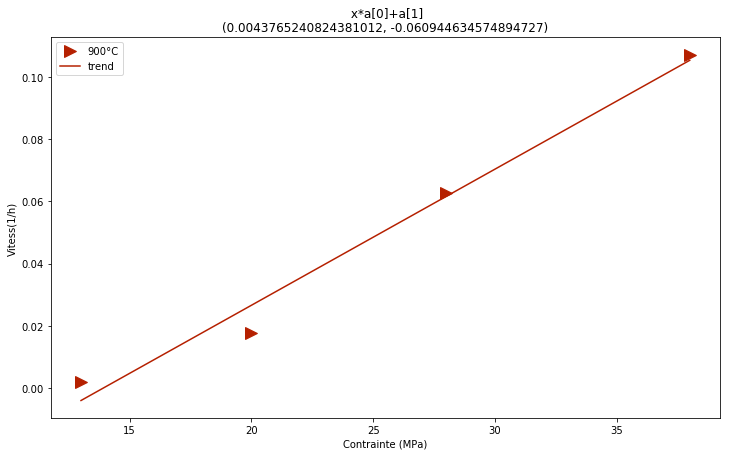

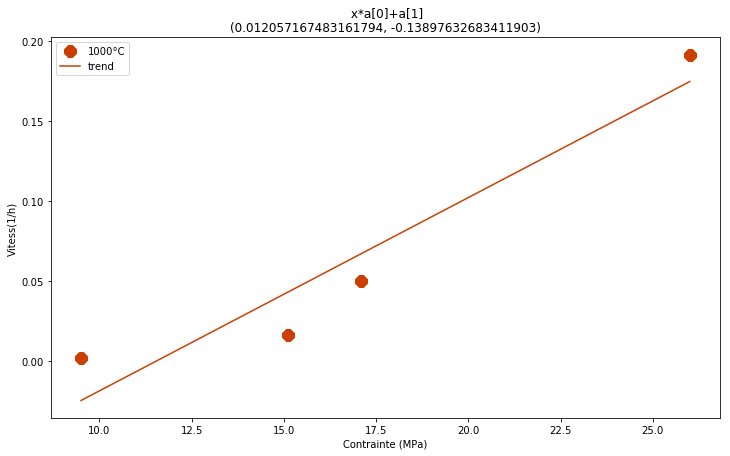

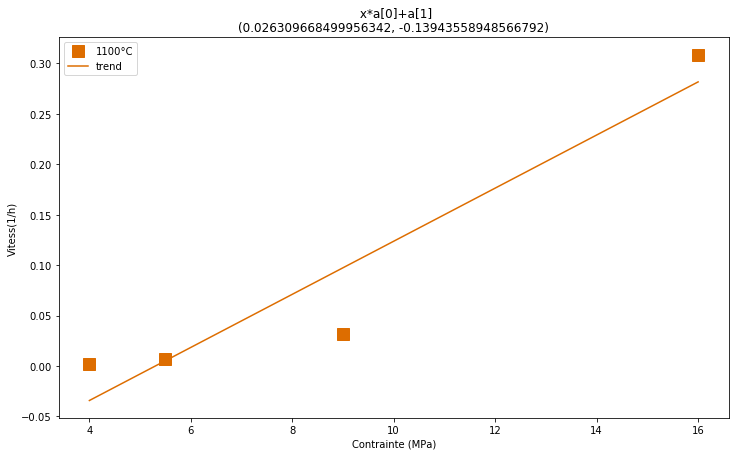

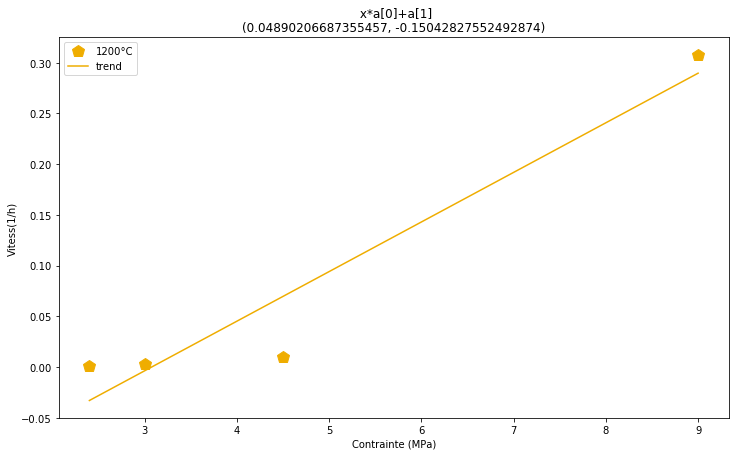

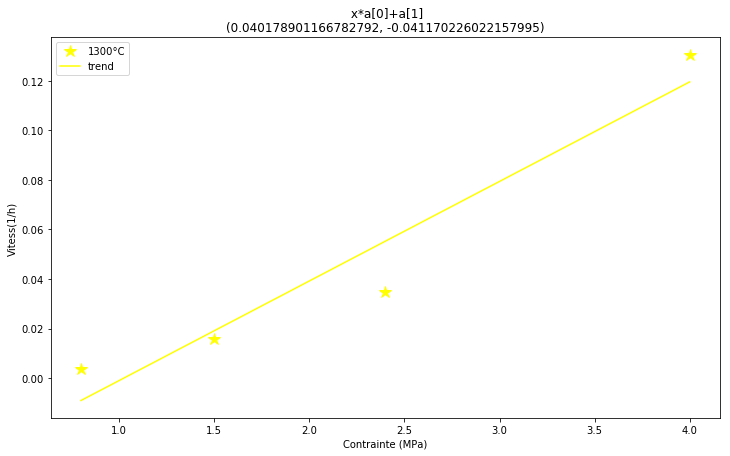

In [44]:
%matplotlib inline
plt.rcParams["figure.figsize"]=[12., 7.]
markers = ('o', 'v', '^', '<', '>', '8', 's', 'p', '*', 'h', 'H', 'D', 'd', 'P', 'X')
cmap = plt.get_cmap('gnuplot')
colors = [cmap(i) for i in np.linspace(0, 1, len(xls2.sheets))]

fnc = inspect.getsource(xls2.trend[0]).split(':')[-1]
for i, _ in enumerate(xls2.sheets):
    _f, _ax = plt.subplots()
    mtrend3 = trend(_ax)
    x,y = vitesse_all_T[_[0]]
    _ax.plot(x, y,  color=colors[i], label= _[0], marker = markers[i],ms=12,linestyle='None')
    _ax.plot(x, map(xls2.trend[0](xls2.trend[1][i]),x), color=colors[i], label= 'trend')
    
    plt.ylabel('Vitess(1/h)')
    plt.xlabel('Contrainte (MPa)')
    plt.title("%s%s" % (fnc,xls2.trend[1][i]))
    plt.legend(loc='best')

# 8: superplots

<IPython.core.display.Javascript object>


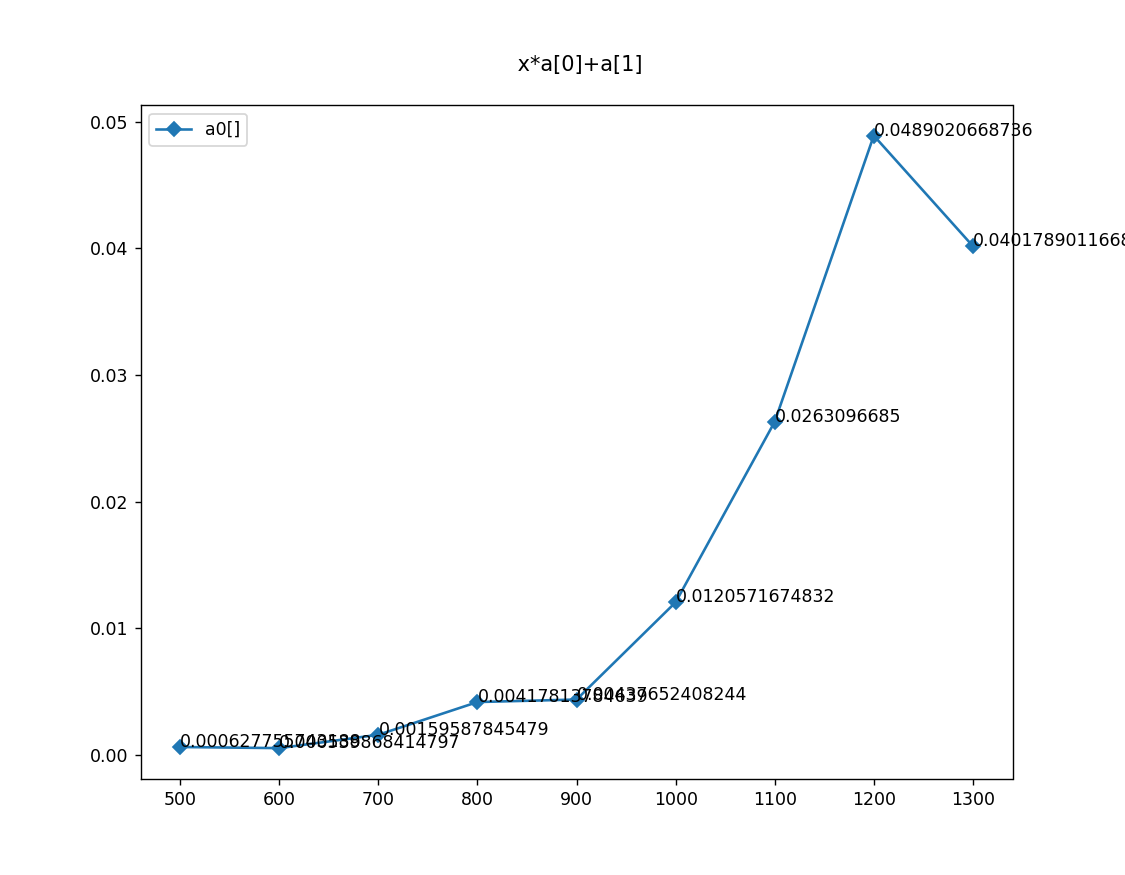

<IPython.core.display.Javascript object>


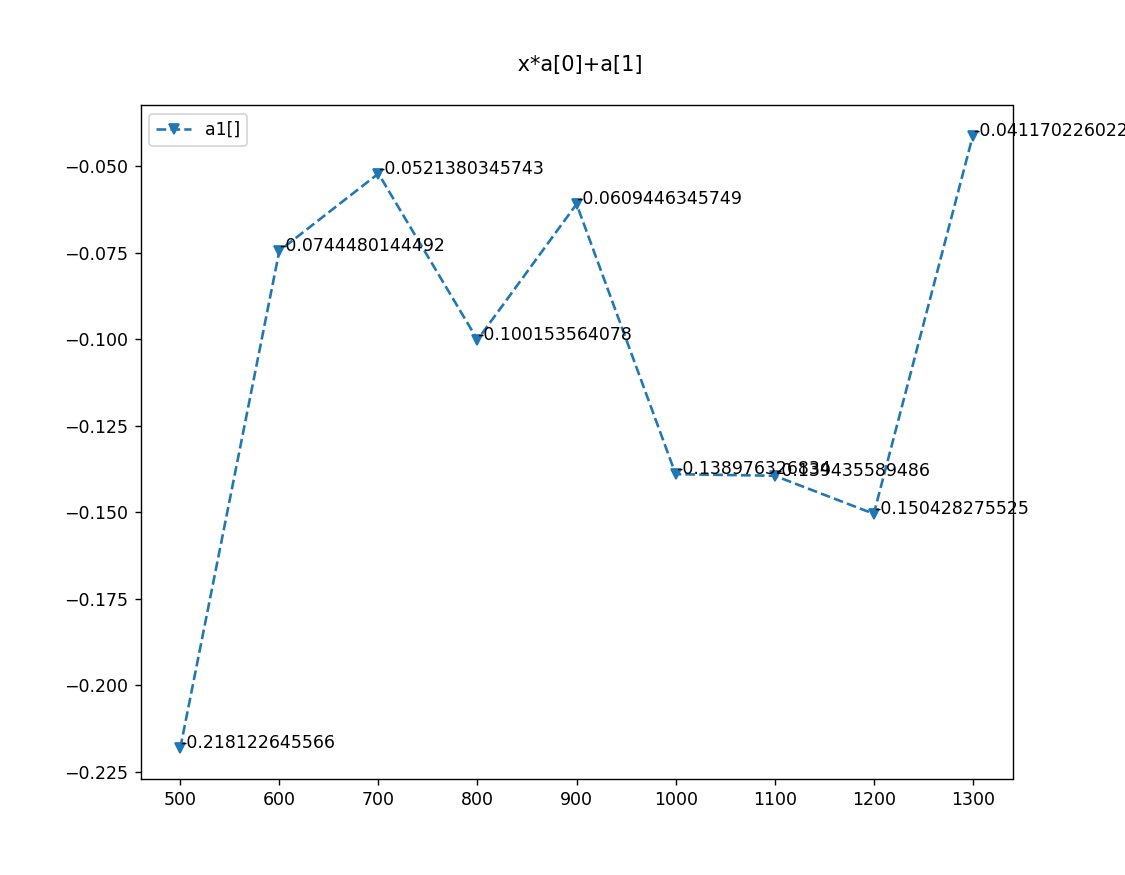

In [47]:
%matplotlib notebook
fnc = inspect.getsource(xls2.trend[0]).split(':')[-1]
xtr = xls2.trend[1]
plt.subplots()
plt.title(fnc)
plt.plot(xls2.XX, [_[0] for _ in xtr],'D',ls='solid',label='a0[]');
plt.legend(loc='upper left')
for i, _ in enumerate(xtr):
  plt.annotate(xtr[i][0], (xls2.XX[i],xtr[i][0]*1.))
plt.subplots()
plt.title(fnc)
plt.plot(xls2.XX, [_[1] for _ in xls2.trend[1]],'v',ls='dashed',label='a1[]');
plt.legend(loc='best')
for i, _ in enumerate(xtr):
  plt.annotate(xtr[i][1], (xls2.XX[i],xtr[i][1]*1.))

# 9: print ALL deriavtives

In [46]:
for _ in xls2.sheets:
    _k = _[0]
    print "'%s':\n\t" % _k ,
    _len = len(vitesse_all_T[_k][0])
    for _j in range(_len):
        print vitesse_all_T[_k][0][_j],',',
    print '\n\t',
    for _j in range(_len):
        print vitesse_all_T[_k][1][_j],',',
    print    

'500 °C':
	425.0 , 425.0 , 400.0 , 385.0 , 360.0 , 325.0 , 
	0.0311166666667 , 0.09395 , 0.0123411643138 , 0.00565142310717 , 0.00360206464482 , 0.000996132070739 ,
'600°C':
	115.0 , 150.0 , 190.0 , 248.0 , 
	0.000688964048603 , 0.00212952524114 , 0.00563622698234 , 0.0732807215333 ,
'700°C':
	25.0 , 40.0 , 70.0 , 90.0 , 
	0.00105519131667 , 0.00467553383718 , 0.0339145220168 , 0.110875266859 ,
'800°C':
	18.0 , 25.0 , 43.0 , 65.0 , 
	0.00209700176367 , 0.0047138047138 , 0.0209777777778 , 0.202495974235 ,
'900°C':
	13.0 , 20.0 , 28.0 , 38.0 , 
	0.00196759259259 , 0.0176037037037 , 0.0627223625602 , 0.107203687005 ,
'1000°C':
	9.5 , 15.1 , 17.1 , 26.0 , 
	0.00220833333333 , 0.0167284586667 , 0.0500912533434 , 0.19133688593 ,
'1100°C':
	4.0 , 5.5 , 9.0 , 16.0 , 
	0.00246259173802 , 0.0070408522091 , 0.0318466600698 , 0.308591101289 ,
'1200°C':
	2.4 , 3.0 , 4.5 , 9.0 , 
	0.00126388888889 , 0.00324126984127 , 0.01 , 0.30803080308 ,
'1300°C':
	0.8 , 1.5 , 2.4 , 4.0 , 
	0.00384035087719 , 0.0

# 10: User interface, make one derivative for one sheet:

In [ ]:
def plot_make(b):
    dsk = b.description.split('[')
    sh = dsk[0]
    pl = dsk[1][0:-1]
    %matplotlib notebook    
    plt.rcParams["figure.figsize"]=[9., 7.]
    xls2.makeplot(sh,pl)

def plots_view(x):
    #clear_output()
    w2.options = w1.value
def plot_select(x):
    #clear_output()
    _i = map(lambda x:x[1],xls2.sheets).index(w1.value)
    w3.description="%s[%s]" % (xls2.sheets[_i][0],x)

w1 = widgets.Select(options=xls2.sheets)
w2 = widgets.Select(options=w1.value)
_i = map(lambda x:x[1],xls2.sheets).index(w1.value)
w3 = widgets.Button(description="%s[%s]" % (xls2.sheets[_i][0],w2.value))

w3.on_click(plot_make)
h = widgets.HBox([w1,w2,w3])
interactive(plots_view,x=w1)
interactive(plot_select, x=w2)
display(h)

# 11: Plotting assistant from cmdline

In [ ]:
_i = 0
for _s in xls2.sheets:
    print '\n', "%d:" % _i, `_s[0]`,'\n\t',
    _i+=1; _j = 0
    for _p in _s[1]:
        print "%d:%r" % (_j, _p),
        _j+=1

def mkplot(nsh,npl):
    xls2.makeplot(xls2.sheets[nsh][0],xls2.sheets[nsh][1][npl])

In [ ]:
%matplotlib inline
plt.rcParams["figure.figsize"]=[13., 7.]
#xls2.makeplot(u'700\xb0C','40:4')
mkplot(0,2)

# make one derivative plot from one sheet via 'plotly':

In [ ]:
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly
import plotly.graph_objs as go
init_notebook_mode()

dsk = w3.description.split('[')
sh = dsk[0]
pl = dsk[1][0:-1]
oneplot = pl.split(':')
xls2.evaluate(sh,int(oneplot[1]))

trace1 = go.Scatter(x=xls2.x, y=xls2.dY, mode = 'markers')
trace2 = go.Scatter(x=xls2.x, y=xls2.ds)
trace3 = go.Scatter(x=[xls2.xmin,], y=[xls2.ymin,], mode = 'markers', name = 'min')

data = [trace1,trace2,trace3]
layout = go.Layout(
    xaxis=dict(
        autorange=True
    ),
    yaxis=dict(
        type='log',
        autorange=True
    )
)
fig = go.Figure(data=data, layout=layout)
iplot(fig)

# show all original plots from workbook:

In [ ]:
%matplotlib inline
plt.rcParams["figure.figsize"]=[14., 8.]
for _ in xls2.sheets:
    dxy =xls2.data[_[0]]
    plt.title(_[0])
    for _c in _[1]:
        _n = int(_c.split(':')[1])
        cr = xls2.cregion(dxy,_n)
        plt.plot(cr[0], cr[1],'-', label=_c)
    plt.ylabel('Elongation(%)')
    plt.xlabel('Time(h)')
    plt.legend(loc='best')
    plt.show()
;